In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [13]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [14]:
LIB = pd.read_csv("LIB.csv").set_index(BOOKS)
TOKEN = pd.read_csv('TOKEN.csv').set_index(OHCO)
VOCAB = pd.read_csv('VOCAB.csv').set_index('term_id')

In [15]:
LIB['author'] = 'austen'

In [21]:
LIB['title'] = ('Mansfield Park', 'Northanger Abbey','Pride and Prejudice')

In [22]:
year = {'book_id':[141,121,42671],'year':[1814,1803,1813]}
year_df = pd.DataFrame(year).set_index('book_id')
LIB = pd.merge(LIB,year_df, how = "inner", on = "book_id" )

In [23]:
LIB

,book_title,book_file,author,title,year
book_id,,,,,
141,"Mansfield Park, by Jane Austen",epubs/AUSTEN_JANE_MANSFIELD_PARK-pg141.txt,austen,Mansfield Park,1814
121,"Northanger Abbey, by Jane Austen",epubs/AUSTEN_JANE_NORTHANGER_ABBEY-pg121.txt,austen,Northanger Abbey,1803
42671,"Pride and Prejudice, by Jane Austen, Edited",epubs/AUSTEN_JANE_PRIDE_AND_PREJUDICE-pg42671.txt,austen,Pride and Prejudice,1813


In [24]:
LIB.to_csv('LIB.csv')

In [32]:
OHCO_src = ['book_id', 'chap_num']
OHCO = ['book_id']

In [33]:
TFIDF = pd.read_csv('TFIDF.csv').set_index('book_id')
DOC = pd.read_csv('DOC.csv')

In [37]:
year_df = pd.DataFrame(year).set_index('book_id')
year_index = year_df.index

In [39]:
doc_list = year_index.to_list()
doc_list

[141, 121, 42671]

In [40]:
TFIDF = TFIDF[TFIDF.index.isin(doc_list)]

In [41]:
TFIDF = TFIDF.groupby(OHCO).mean()

In [42]:
DOC = pd.DataFrame(doc_list)

In [43]:
DOC.columns = ['book_id']
DOC.index.name = 'doc_id'
DOC['title'] = DOC.book_id.map(LIB.author) \
    + '-' + DOC[OHCO].apply(lambda x: x.astype('str').str.cat(sep='-'), 1) \
    + ': '+ DOC.book_id.map(LIB.title) 

DOC


,book_id,title
doc_id,,
0,141,austen-141: Mansfield Park
1,121,austen-121: Northanger Abbey
2,42671,austen-42671: Pride and Prejudice


clustering

In [44]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [45]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [46]:
PAIRS.shape

(3, 0)

In [47]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (1, 2)]

compute distances

In [48]:
%time PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')

CPU times: user 2.01 ms, sys: 2.25 ms, total: 4.26 ms
Wall time: 5.28 ms


In [49]:
%time PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')

CPU times: user 4.05 ms, sys: 12.3 ms, total: 16.4 ms
Wall time: 20.1 ms


In [50]:
%time PAIRS['cosine'] = pdist(TFIDF, 'cosine')

CPU times: user 3.45 ms, sys: 1.91 ms, total: 5.36 ms
Wall time: 3.69 ms


In [51]:
%time PAIRS['jaccard'] = pdist(L0, 'jaccard') # Fast, and similar to js

CPU times: user 3.83 ms, sys: 3.3 ms, total: 7.13 ms
Wall time: 8.98 ms


In [52]:
%time PAIRS['dice'] = pdist(L0, 'dice')

CPU times: user 2.25 ms, sys: 1.48 ms, total: 3.73 ms
Wall time: 3.1 ms


In [53]:
%time PAIRS['js'] = pdist(L1, 'jensenshannon') # Turns out to be really slow

CPU times: user 3.84 ms, sys: 3.06 ms, total: 6.9 ms
Wall time: 4.67 ms


In [54]:
%time PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

CPU times: user 3.53 ms, sys: 3.91 ms, total: 7.45 ms
Wall time: 10.4 ms


In [55]:
%time PAIRS['hamming'] = pdist(TFIDF, 'hamming') # Should be the same as cosine (colinear)

CPU times: user 2.91 ms, sys: 2.25 ms, total: 5.16 ms
Wall time: 5.71 ms


In [56]:
PAIRS.head()

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                 
0     1       0.051848   0.004240  0.995233  0.874404  0.776837  0.795657   
      2       0.052370   0.004259  0.980745  0.921319  0.854117  0.806711   
1     2       0.054028   0.005023  0.997691  0.841043  0.725689  0.786196   

             euclidean2   hamming  
doc_a doc_b                        
0     1        1.410839  0.547467  
      2        1.400532  0.489901  
1     2        1.412580  0.587696

In [57]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

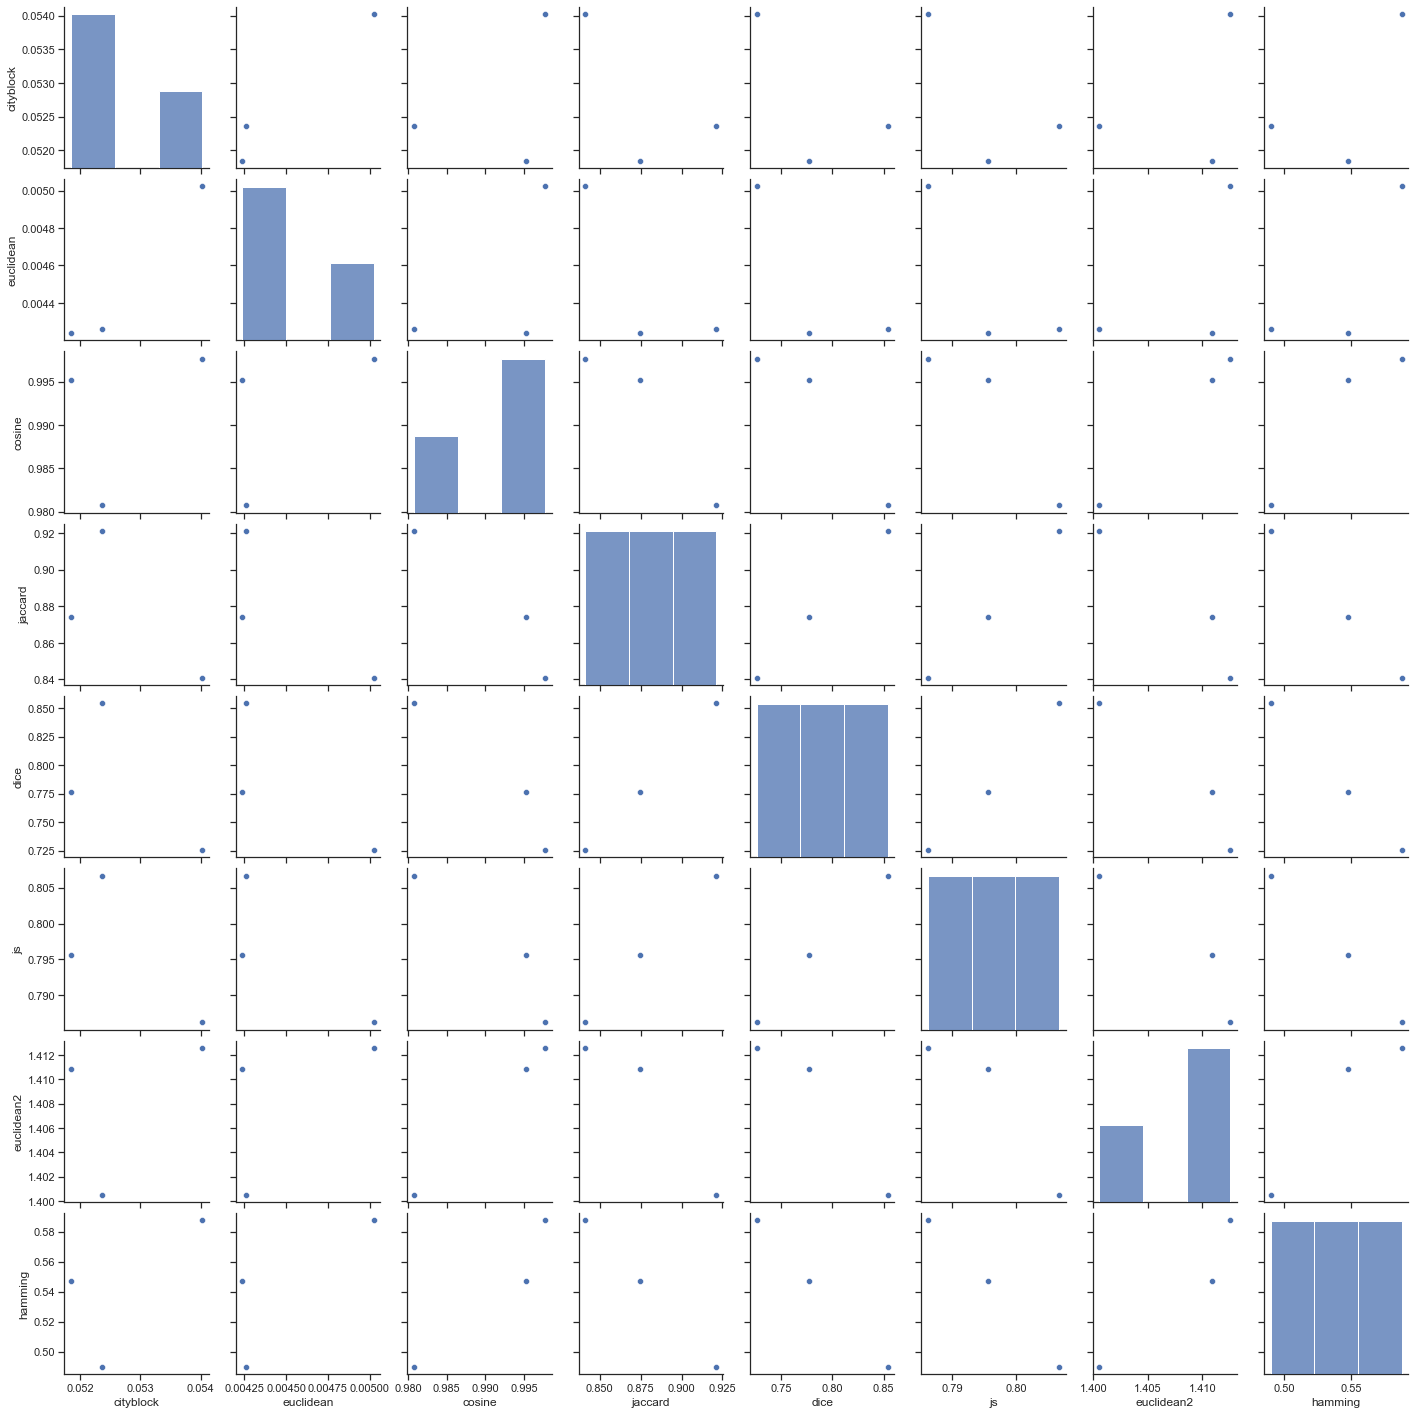

In [58]:
sns.pairplot(SAMPLE)

In [59]:
PAIRS.sort_values('cosine').head(20).style.background_gradient('YlGn')

hiearchical

In [60]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [61]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=list(labels), 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

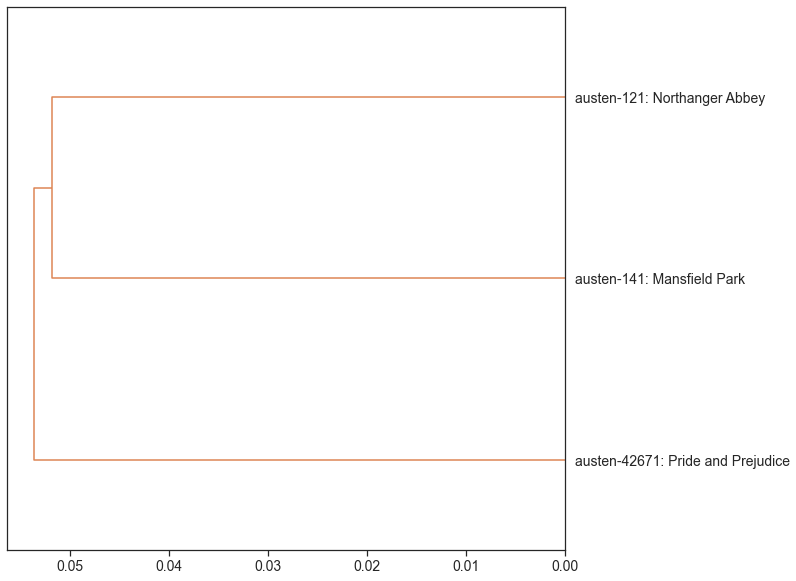

In [62]:
hca(PAIRS.cityblock, color_thresh=1)

<Figure size 432x288 with 0 Axes>

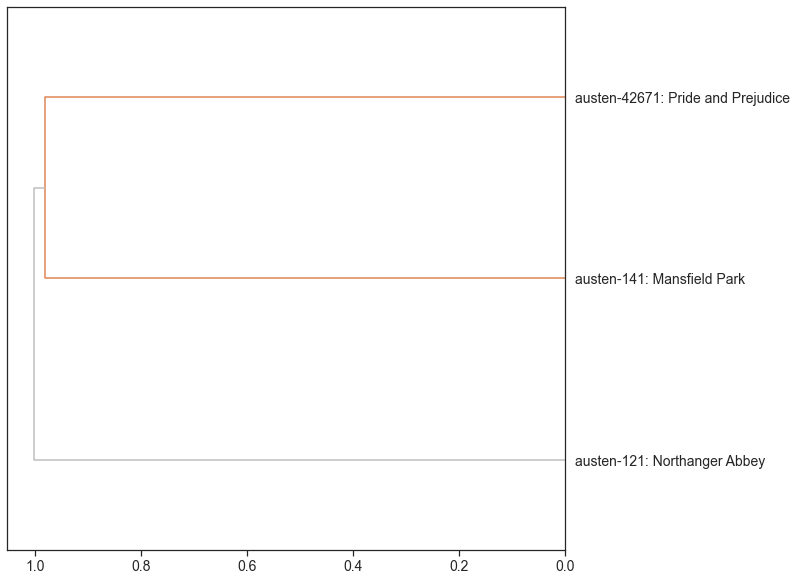

In [63]:
hca(PAIRS.cosine, color_thresh=1)

<Figure size 432x288 with 0 Axes>

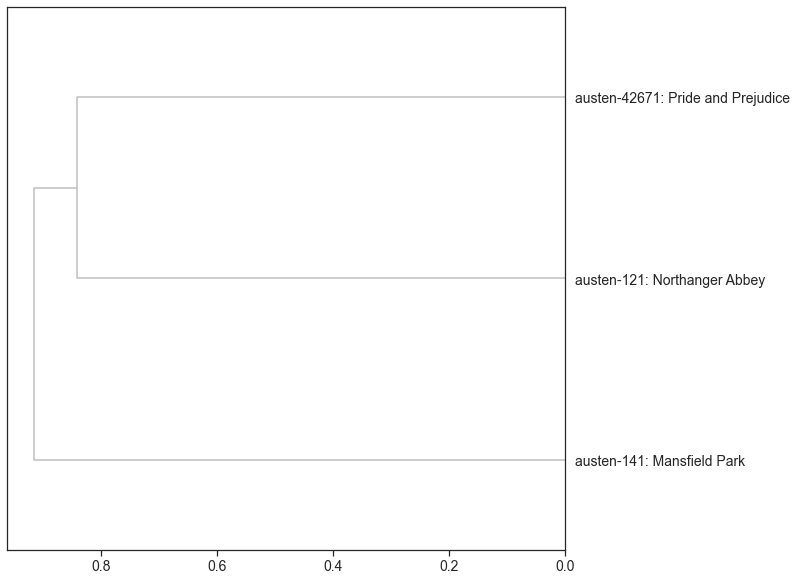

In [64]:
hca(PAIRS.jaccard, color_thresh=.6)

<Figure size 432x288 with 0 Axes>

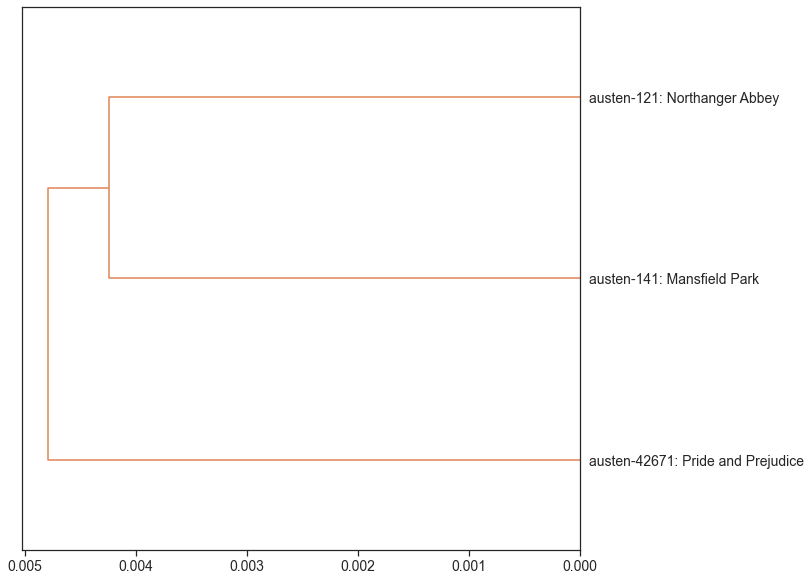

In [65]:
hca(PAIRS.euclidean, color_thresh=.3)

<Figure size 432x288 with 0 Axes>

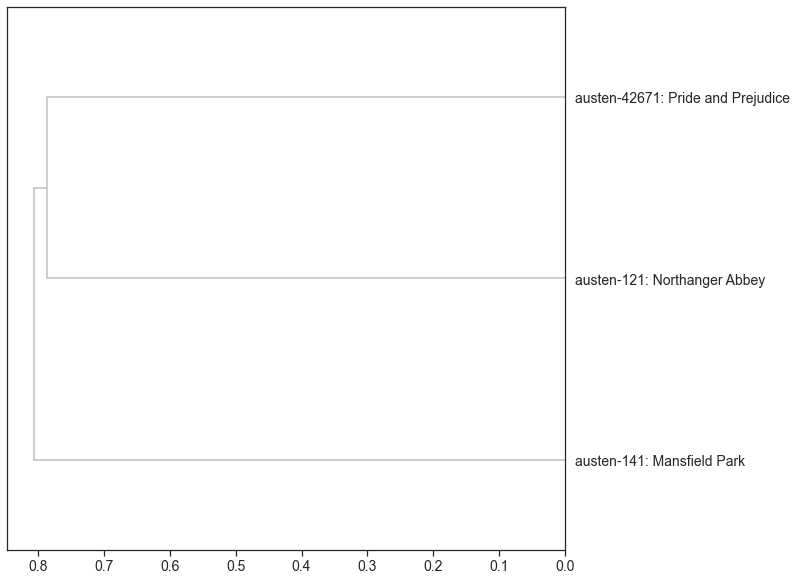

In [66]:
hca(PAIRS.js, color_thresh=.6)

<Figure size 432x288 with 0 Axes>

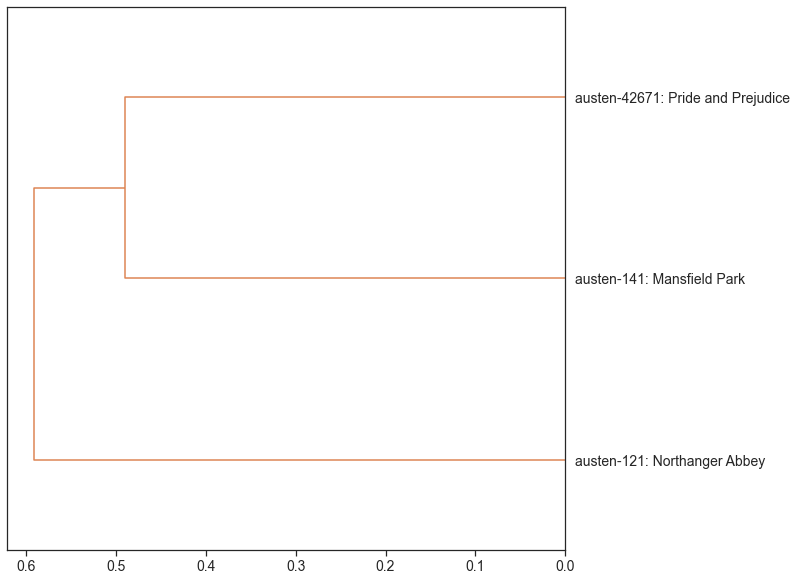

In [67]:
hca(PAIRS.hamming, color_thresh=.6)